In [6]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

from tqdm import trange, tqdm

from collections import defaultdict
from itertools import combinations

In [25]:
# # Read DBLP
edges = pd.read_csv("../../SNAP/com-youtube.ungraph.txt", sep='\t', comment="#")
coms = []
with open("../../SNAP/com-youtube.all.cmty.txt", "r") as infile:
    for line in infile:
        x = line[:-1]  # drop trailing newline
        x = x.split('\t')
        coms.append(frozenset([int(y) for y in x])) ## map to 0-based

g = ig.Graph.DataFrame(edges, directed=False)

c = [set() for _ in range(g.vcount())]
for i, com in enumerate(coms):
    for v in com:
        c[v].add(i)
        #print(f"Vertex {v} in community {i}")
        #print(f"Vetrex {v} is now in {len(c[v])} coms")
c = [frozenset(i) for i in c] 
g.vs["comms"] = c

g = g.subgraph(np.arange(g.vcount())[np.array(g.degree()) > 0])  # Vertex list is not continugous, degree 0 vertices get added


print(f"{g.vcount()} vertices")
print(f"{g.ecount()} edges")
print(f"{len(coms)} communities")

# Dropping some vars to free up memory
del edges


1134890 vertices
2987623 edges
16386 communities


Min size: 2
Max size: 3001
Mean: 7.884901745392408


Text(0, 0.5, 'Frequency')

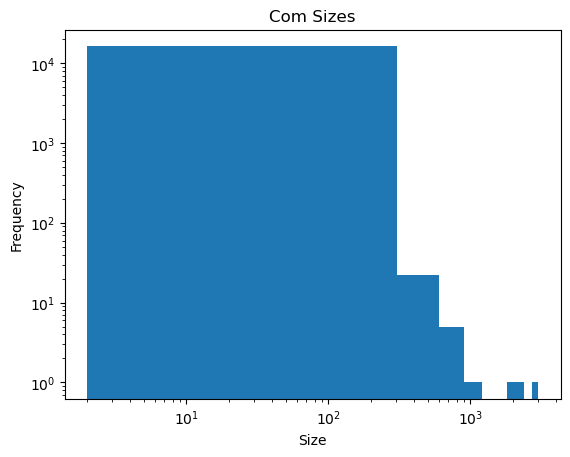

In [26]:
com_sizes = np.array([len(com) for com in coms])

print(f"Min size: {np.min(com_sizes)}")
print(f"Max size: {np.max(com_sizes)}")
print(f"Mean: {np.mean(com_sizes)}")

plt.hist(com_sizes, log=True)
plt.xscale("log")
plt.title("Com Sizes")
plt.xlabel("Size")
plt.ylabel("Frequency")

Mean: 0.11384539470785715
Mean for non-zero: 2.4528144280968203
Median: 0.0
Median for non-zero: 1.0
Max: 227
# no coms: 1082215
% no coms: 0.9535858100785098


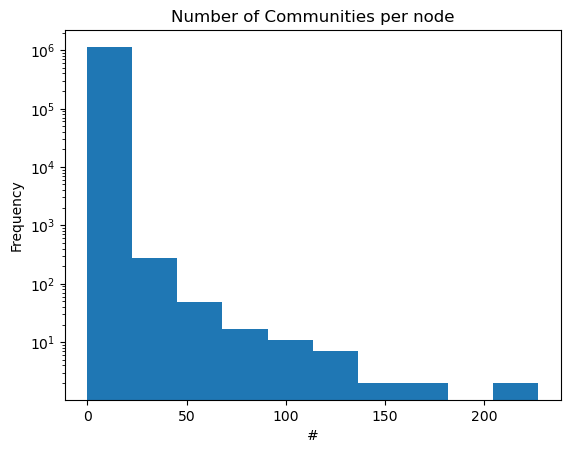

In [27]:
lens = np.array([len(i) for i in g.vs["comms"]])
plt.hist(lens, log=True)
plt.title("Number of Communities per node")
plt.xlabel("#")
plt.ylabel("Frequency")

print(f"Mean: {np.mean(lens)}")
print(f"Mean for non-zero: {np.mean(lens[lens>0])}")
print(f"Median: {np.median(lens)}")
print(f"Median for non-zero: {np.median(lens[lens>0])}")
print(f"Max: {np.max(lens)}")
print(f"# no coms: {np.sum(lens == 0)}")
print(f"% no coms: {np.sum(lens == 0) / len(lens)}")

In [28]:
print("Graph measurements for generating similar ABCDoo graphs.")

print(f"n = {g.vcount()}")
print(f"nout = {np.sum(lens == 0)}")
eta = np.mean(lens[lens>0])
print(f"eta = {eta: .2f}")

degrees = np.array(g.degree())
print(f"d_min = {np.min(degrees)}")
print(f"d_max = {np.max(degrees)}")
print(f"t1 = {powerlaw.Fit(degrees, discrete=True, verbose=False).power_law.alpha: .2f}         ") # Spaces are required to prevent some buffer overflow from printing a progress notice

com_sizes = np.array([len(com) for com in coms])

scaled_com_sizes = com_sizes/eta
large_com_sizes = scaled_com_sizes[scaled_com_sizes > 10] # Remove very small communities

print(f"c_min = {int(np.min(scaled_com_sizes))}")
print(f"c_max = {int(np.max(scaled_com_sizes))}")

print(f"t2 = {powerlaw.Fit(large_com_sizes, discrete=True, verbose=False, xmin=np.min(large_com_sizes)).power_law.alpha: .2f}         ") # Spaces are required to prevent some buffer overflow from printing a progress notice

Graph measurements for generating similar ABCDoo graphs.
n = 1134890
nout = 1082215
eta =  2.45
d_min = 1
d_max = 28754
t1 =  2.14         
c_min = 0
c_max = 1223
t2 =  2.17         


In [ ]:
two_overlaps = defaultdict(int)
three_overlaps = defaultdict(int)
four_overlaps = defaultdict(int)

skipped = 0
for com in tqdm(g.vs["comms"]):
    if len(com) > 160:
        #print(f"Skipping node with {len(com)} communities")
        skipped += 1
        continue

    for k2 in combinations(com, 2):
        two_overlaps[tuple(sorted(k2))] += 1
    for k3 in combinations(com, 3):
        three_overlaps[tuple(sorted(k3))] += 1
    for k4 in combinations(com, 4):
        four_overlaps[tuple(sorted(k4))] += 1


100%|██████████| 1134890/1134890 [02:35<00:00, 7277.42it/s]  


In [ ]:
print(f"Found {len(two_overlaps)} pairs of communities that overlap.")
print(f"Found {len(three_overlaps)} triples of communities that overlap.")
print(f"Found {len(four_overlaps)} quadruples of communities that overlap.")

print(f"Skipped {skipped} nodes.")

Found 352785 pairs of communities that overlap.
Found 7805892 triples of communities that overlap.
Found 174799946 quadruples of communities that overlap.
Skipped 4 nodes.


Bins: [   1    2    5   12   29   69  161  376  877 2048]
{'2 Communities': array([256844,  80593,  11447,   3043,    699,    144,     14,      1,
            0]), '3 Communities': array([6766468,  950830,   78951,    8893,     711,      38,       1,
             0,       0]), '4 Communities': array([160040706,  14266428,    477686,     14877,       247,         2,
               0,         0,         0])}


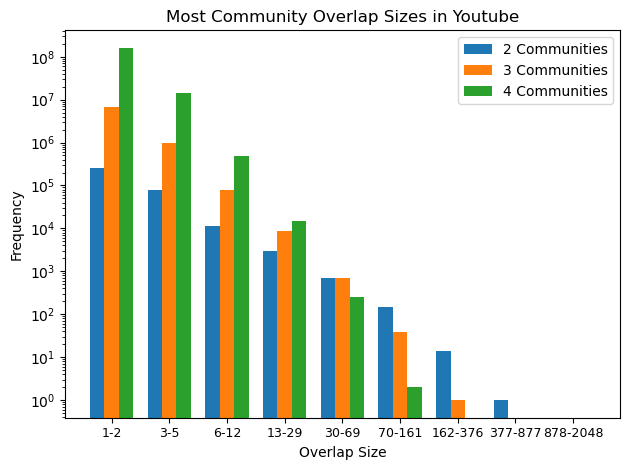

In [39]:
bins = np.logspace(0, 11, num=10, base=2, dtype="int64")
#bins = np.linspace(0, 700, num=10)
print(f"Bins: {bins}")

two_counts = np.histogram(list(two_overlaps.values()), bins=bins)[0]
three_counts = np.histogram(list(three_overlaps.values()), bins=bins)[0]
four_counts = np.histogram(list(four_overlaps.values()), bins=bins)[0]

bin_counts = {
    "2 Communities": two_counts,
    "3 Communities": three_counts,
    "4 Communities": four_counts
}
print(bin_counts)

x = np.arange(len(bins)-1)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

bin_labels = [str(bins[i]+1)+"-"+str(bins[i+1]) for i in range(len(bins)-1)]
bin_labels[0] = "1-2"
bin_labels

fig, ax = plt.subplots()
#plt.grid()

for n_comms, count in bin_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, count, width, label=n_comms)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_xlabel("Overlap Size")
ax.set_title('Most Community Overlap Sizes in LiveJournal')
ax.set_yscale('log')
ax.set_xticks(x + width, bin_labels, fontsize=9)
ax.legend()
#ax.set_ylim(0, 250)

plt.tight_layout()
plt.savefig("lj-overlaps.png")
plt.show()


In [28]:
## Estimate Powerlaw of each 
import powerlaw

## estimates for l' (xmin) and the exponent
print("Two Overlaps:")
vals = list(two_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)
print("\n\n")

print("Three Overlaps:")
vals = list(three_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)
print("\n\n")

print("Four Overlaps:")
vals = list(four_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)

Two Overlaps:
Calculating best minimal value for power law fit
xmin progress: 99%
Exponent: 2.147245663801876
l': 3.0
KS statistic: 0.015825968888011133
Compared to Exponential 84.7315584898796 0.0


Assuming nested distributions


Compared to Truncated -9.466764176358167 0.0



Three Overlaps:
Calculating best minimal value for power law fit
xmin progress: 99%
Exponent: 2.1123679292667106
l': 31.0
KS statistic: 0.009748620368483896
Compared to Exponential 75.320224899997 0.0


Assuming nested distributions


Compared to Truncated -19.389985990654505 0.0



Four Overlaps:
Calculating best minimal value for power law fit
xmin progress: 99%
Exponent: 2.242950851437889
l': 29.0
KS statistic: 0.009869341678912291
Compared to Exponential 154.33600201641747 0.0


Assuming nested distributions


Compared to Truncated -34.04116269677669 0.0


# Repeat with ABCDoo

In [2]:
#path = '../../ABCDGraphGenerator.jl/'
path = 'example2/'
#path = '../Datasets/ABCDoo/'
def readGraph():
    ## read edges, build graph
    fn = path+'networkfile0.25_1.5_1_3.txt'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = path+'communityfile0.25_1.5_1_3.txt'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            L.append([int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]) ## map to 0-based
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G

g = readGraph()
print(f"{g.vcount()} vertices")
print(f"{g.ecount()} edges")

10000 vertices
101285 edges


Min size: 0
Max size: 1046
Mean: 234.01612903225808


Text(0, 0.5, 'Frequency')

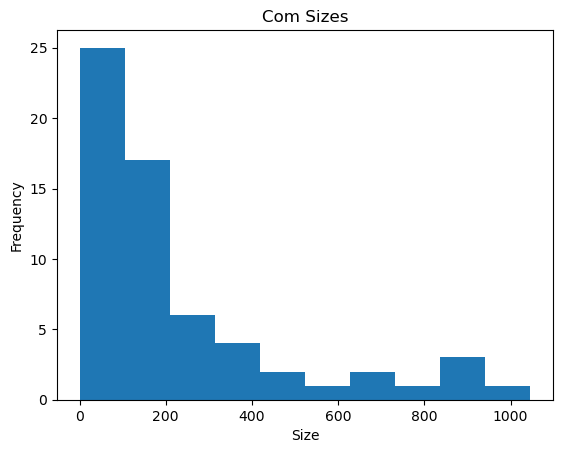

In [3]:
coms = defaultdict(set)
for i, com in enumerate(g.vs["comms"]):
    for c in com:
        coms[c].add(i)
coms[0] = set()
coms = list(coms.values())

com_sizes = np.array([len(com) for com in coms])[:-1]

print(f"Min size: {np.min(com_sizes)}")
print(f"Max size: {np.max(com_sizes)}")
print(f"Mean: {np.mean(com_sizes)}")

plt.hist(com_sizes)
#plt.xscale("log")
#plt.yscale("log")
plt.title("Com Sizes")
plt.xlabel("Size")
plt.ylabel("Frequency")

Mean: 1.4876
Mean for non-zero: 1.4876
Median: 1.0
Median for non-zero: 1.0
Max: 4
# no coms: 0
% no coms: 0.0


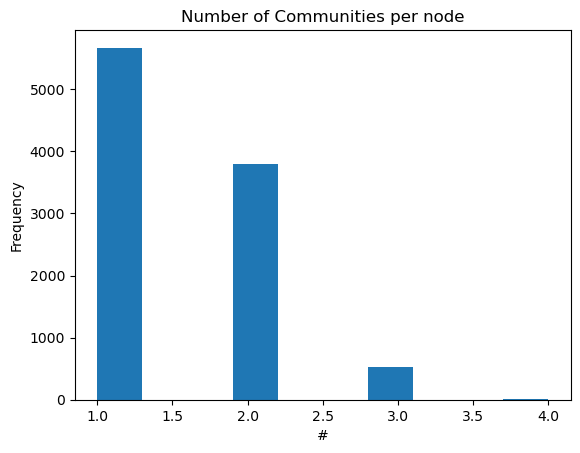

In [4]:
lens = [len(i) for i in g.vs["comms"]]
plt.hist(lens)
plt.title("Number of Communities per node")
plt.xlabel("#")
plt.ylabel("Frequency")

print(f"Mean: {np.mean(lens)}")
print(f"Mean for non-zero: {np.mean(np.array(lens)[np.array(lens)>0])}")
print(f"Median: {np.median(lens)}")
print(f"Median for non-zero: {np.median(np.array(lens)[np.array(lens)>0])}")
print(f"Max: {np.max(lens)}")
print(f"# no coms: {np.sum(np.array(lens) == 0)}")
print(f"% no coms: {np.sum(np.array(lens) == 0) / len(lens)}")

In [5]:
two_overlaps = defaultdict(int)
three_overlaps = defaultdict(int)
four_overlaps = defaultdict(int)

skipped = 0
for com in tqdm(g.vs["comms"]):
    if len(com) > 150:
        print(f"Skipping node with {len(com)} communities")
        skipped += 1
        continue

    for k2 in combinations(com, 2):
        two_overlaps[frozenset(k2)] += 1
    for k3 in combinations(com, 3):
        three_overlaps[frozenset(k3)] += 1
    for k4 in combinations(com, 4):
        four_overlaps[frozenset(k4)] += 1


100%|██████████| 10000/10000 [00:00<00:00, 1263763.30it/s]


In [6]:
np.max(list(two_overlaps.values()))

210

Bins: [   1    2    5   12   29   69  161  376  877 2048]
{'2 Communities': array([20, 35, 54, 57, 29, 17,  4,  0,  0]), '3 Communities': array([40, 41, 19,  9,  3,  0,  0,  0,  0]), '4 Communities': array([1, 2, 0, 0, 0, 0, 0, 0, 0])}


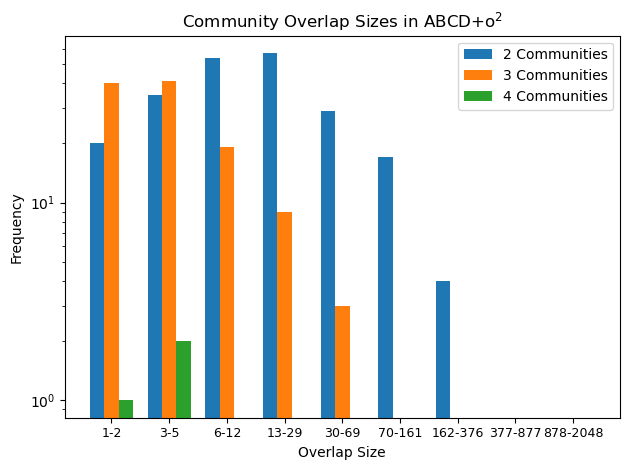

In [7]:
bins = np.logspace(0, 11, num=10, base=2, dtype="int64")
#bins = np.linspace(0, 700, num=10)
print(f"Bins: {bins}")

two_counts = np.histogram(list(two_overlaps.values()), bins=bins)[0]
three_counts = np.histogram(list(three_overlaps.values()), bins=bins)[0]
four_counts = np.histogram(list(four_overlaps.values()), bins=bins)[0]

bin_counts = {
    "2 Communities": two_counts,
    "3 Communities": three_counts,
    "4 Communities": four_counts
}
print(bin_counts)

x = np.arange(len(bins)-1)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

bin_labels = [str(bins[i]+1)+"-"+str(bins[i+1]) for i in range(len(bins)-1)]
bin_labels[0] = "1-2"
bin_labels

fig, ax = plt.subplots()
#plt.grid()

for n_comms, count in bin_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, count, width, label=n_comms)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_xlabel("Overlap Size")
ax.set_title('Community Overlap Sizes in ABCD+o'+r'$^2$')
ax.set_yscale('log')
ax.set_xticks(x + width, bin_labels, fontsize=9)
ax.legend()
#ax.set_ylim(0, 250)

plt.tight_layout()
plt.savefig("abcdoo-overlaps.png")
plt.show()

In [8]:
## Estimate Powerlaw of each 
import powerlaw

## estimates for l' (xmin) and the exponent
print("Two Overlaps:")
vals = list(two_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)
print("\n\n")

print("Three Overlaps:")
vals = list(three_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)
print("\n\n")

print("Four Overlaps:")
vals = list(four_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)

Two Overlaps:
Calculating best minimal value for power law fit
xmin progress: 98%
Exponent: 2.1552035253997497
l': 17.0
KS statistic: 0.07528342133830679
Compared to Exponential 0.804019947531899 0.4213854548554369


Assuming nested distributions


Compared to Truncated -1.8989677130890792 0.009826061759729221



Three Overlaps:
Calculating best minimal value for power law fit
xmin progress: 94%
Exponent: 2.0342036436739455
l': 3.0
KS statistic: 0.062299456674962395
Compared to Exponential 0.6402430184046841 0.5220146194473657


Assuming nested distributions


Compared to Truncated -1.7247309401599449 0.03241727324403909



Four Overlaps:
Calculating best minimal value for power law fit
xmin progress: 50%
Exponent: 1.721347520444482
l': 1.0
KS statistic: 0.16333629193886096
Compared to Exponential -1.6341473935335442 0.1022279054448141
Compared to Truncated -1.2235424090831897 0.3754826586872333


Assuming nested distributions


In [ ]:
# d=2
# two 1.9
# three 2.3
# four 2.9

# d=3
# two 1.7
# three 1.9
# four 2.25

# d=4
# two 1.9
# three 3
# four 1.9